<a href="https://colab.research.google.com/github/MovinduSenura/Chest-Xray-Pneumonia-Detection/blob/dev-senura/notebooks/CustomCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTS

import os
import sys
import importlib
from google.colab import drive
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [2]:
# CLONE GITHUB REPOSITORY

if not os.path.exists('Chest-Xray-Pneumonia-Detection'):
    !git clone https://github.com/MovinduSenura/Chest-Xray-Pneumonia-Detection.git

Cloning into 'Chest-Xray-Pneumonia-Detection'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 103 (delta 21), reused 5 (delta 5), pack-reused 69 (from 2)
Receiving objects: 100% (103/103), 49.91 KiB | 798.00 KiB/s, done.
Resolving deltas: 100% (37/37), done.


In [3]:
# ADD NOTEBOOKS FOLDER TO PYTHON PATH

sys.path.append('/content/Chest-Xray-Pneumonia-Detection/notebooks/')

In [4]:
# IMPORT AND RELOAD PREPROCESSING MODULE

import preprocessing
importlib.reload(preprocessing)    # reloads latest version
from preprocessing import create_generators

In [5]:
# MOUNT GOOGLE DRIVE (DATASET LOCATION)

drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/DL_Assignment/chest_xray/'

Mounted at /content/drive


In [6]:
# CREATE TRAIN/VAL/TEST GENERATORS

train_gen, val_gen, test_gen = create_generators(DATA_DIR)
print("✅ Data generators created successfully!\n")

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
✅ Data generators created successfully!



In [7]:
# BUILD CUSTOM CNN MODEL WITH REGULARIZATION

model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005), input_shape=(224,224,3)),
    BatchNormalization(),
    Conv2D(32, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Convolutional Block 2
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    # Convolutional Block 3
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Conv2D(128, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    # Convolutional Block 4 (NEW)
    Conv2D(256, (3,3), activation='relu', padding='same',
           kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.4),

    # Global Average Pooling (replaces Flatten)
    GlobalAveragePooling2D(),

    # Fully Connected Layers with Regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile model with lower learning rate and more metrics
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 684,833 (2.61 MB)

 Trainable params: 682,913 (2.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [8]:
# SETUP CALLBACKS FOR BETTER TRAINING

callbacks = [
    # Early stopping - stops training if val_loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate when validation loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    ),

    # Save the best model during training
    ModelCheckpoint(
        '/content/drive/MyDrive/DL_Assignment/best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

In [9]:
# TRAIN THE MODEL

print("\n🚀 Starting model training...\n")
history = model.fit(
    train_gen,
    epochs=5,  # Increased epochs - early stopping will handle it
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)


🚀 Starting model training...



/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - Precision: 0.8823 - Recall: 0.7613 - accuracy: 0.7467 - loss: 1.0082 
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/drive/MyDrive/DL_Assignment/best_model.keras
163/163 ━━━━━━━━━━━━━━━━━━━━ 3232s 20s/step - Precision: 0.8825 - Recall: 0.7617 - accuracy: 0.7471 - loss: 1.0075 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 2.4088 - learning_rate: 1.0000e-04
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - Precision: 0.9253 - Recall: 0.8888 - accuracy: 0.8645 - loss: 0.8148 
Epoch 2: val_accuracy did not improve from 0.50000
163/163 ━━━━━━━━━━━━━━━━━━━━ 3192s 20s/step - Precision: 0.9253 - Recall: 0.8888 - accuracy: 0.8646 - loss: 0.8146 - val_Precision: 0.5000 - val_Recall: 1.0000 - val_accuracy: 0.5000 - val_loss: 4.6651 - learning_rate: 1.0000e-04
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - Precision: 0.9401 - Recall: 0.9079 - accuracy: 0.8892 - loss: 0.732

In [10]:
# EVALUATE MODEL ON TEST DATA

test_loss, test_acc, test_precision, test_recall = model.evaluate(test_gen)
test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

print(f"\n✅ Test Accuracy:  {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall:    {test_recall:.4f}")
print(f"✅ Test F1-Score:  {test_f1:.4f}")
print(f"✅ Test Loss:      {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 224s 11s/step - Precision: 0.2984 - Recall: 0.6667 - accuracy: 0.2984 - loss: 3.1859

✅ Test Accuracy:  0.6250 (62.50%)
✅ Test Precision: 0.6250
✅ Test Recall:    1.0000
✅ Test F1-Score:  0.7692
✅ Test Loss:      1.9312


In [11]:
# TRAINING SUMMARY

print(f"\nTotal Epochs Trained: {len(history.history['loss'])}")
print(f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
overfitting_gap = history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
print(f"Overfitting Gap: {overfitting_gap:.4f}")



Total Epochs Trained: 5
Best Validation Accuracy: 0.5000
Final Training Accuracy: 0.9064
Final Validation Accuracy: 0.5000
Overfitting Gap: 0.4064


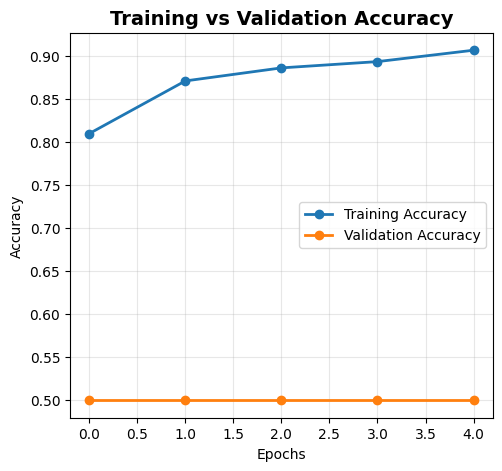

In [12]:
# PLOT TRAINING VS VALIDATION ACCURACY

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o', linewidth=2)
plt.title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

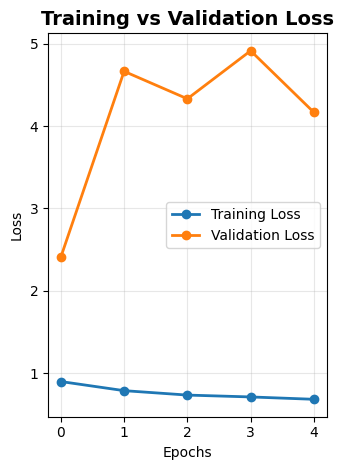

In [13]:
# PLOT TRAINING VS VALIDATION LOSS

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', marker='o', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o', linewidth=2)
plt.title('Training vs Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DL_Assignment/training_history.png', dpi=300, bbox_inches='tight')
plt.show()

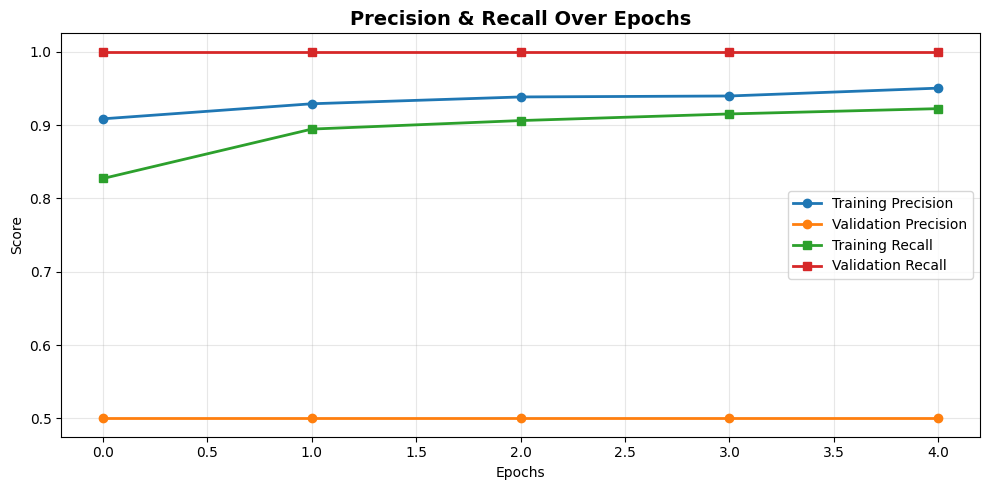

In [16]:
# PLOT PRECISION AND RECALL

plt.figure(figsize=(10, 5))
plt.plot(history.history['Precision'], label='Training Precision', marker='o', linewidth=2)
plt.plot(history.history['val_Precision'], label='Validation Precision', marker='o', linewidth=2)
plt.plot(history.history['Recall'], label='Training Recall', marker='s', linewidth=2)
plt.plot(history.history['val_Recall'], label='Validation Recall', marker='s', linewidth=2)
plt.title('Precision & Recall Over Epochs', fontsize=14, fontweight='bold')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DL_Assignment/precision_recall.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# PREDICT ON TEST DATA

y_pred = model.predict(test_gen)
y_pred_classes = np.where(y_pred > 0.5, 1, 0).flatten()
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

20/20 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step


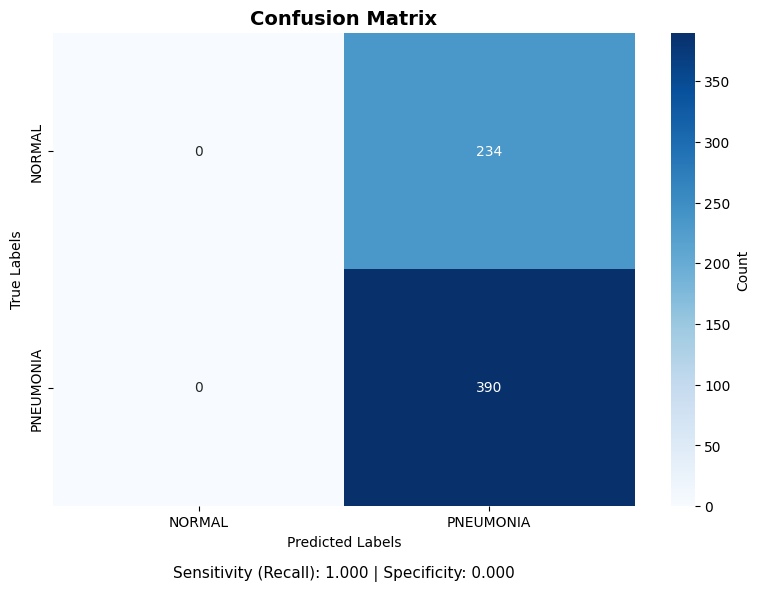


📈 Confusion Matrix Breakdown:
True Positives (TP):  390
True Negatives (TN):  0
False Positives (FP): 234
False Negatives (FN): 0

Sensitivity (Recall): 1.0000
Specificity:          0.0000


In [18]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Add sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
plt.text(0.5, -0.15, f'Sensitivity (Recall): {sensitivity:.3f} | Specificity: {specificity:.3f}',
         ha='center', transform=plt.gca().transAxes, fontsize=11)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DL_Assignment/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📈 Confusion Matrix Breakdown:")
print(f"True Positives (TP):  {tp}")
print(f"True Negatives (TN):  {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity:          {specificity:.4f}")

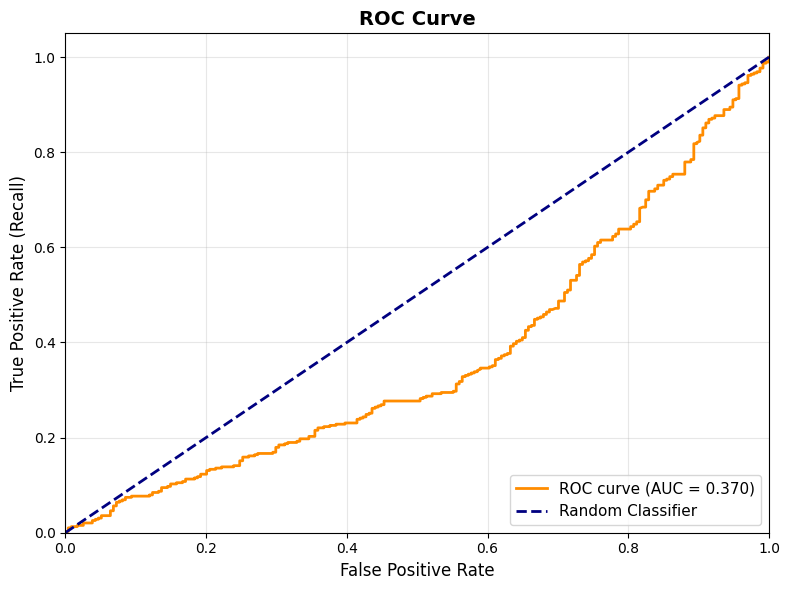


📊 ROC AUC Score: 0.3697
   Room for improvement 📈


In [19]:
# ROC CURVE

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/DL_Assignment/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n📊 ROC AUC Score: {roc_auc:.4f}")
if roc_auc >= 0.9:
    print("   Outstanding performance! 🏆")
elif roc_auc >= 0.8:
    print("   Excellent performance! 🎉")
elif roc_auc >= 0.7:
    print("   Good performance! 👍")
else:
    print("   Room for improvement 📈")

In [20]:
# CLASSIFICATION REPORT

print("📋 CLASSIFICATION REPORT")

print(classification_report(y_true, y_pred_classes, target_names=class_labels, digits=4))

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      NORMAL     0.0000    0.0000    0.0000       234
   PNEUMONIA     0.6250    1.0000    0.7692       390

    accuracy                         0.6250       624
   macro avg     0.3125    0.5000    0.3846       624
weighted avg     0.3906    0.6250    0.4808       624



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# SAVE TRAINED MODEL

model.save('/content/drive/MyDrive/DL_Assignment/CustomCNN_Optimized.keras')
print("\n✅ Optimized model saved successfully to Google Drive!")
print("   Location: /content/drive/MyDrive/DL_Assignment/CustomCNN_Optimized.keras")



✅ Optimized model saved successfully to Google Drive!
   Location: /content/drive/MyDrive/DL_Assignment/CustomCNN_Optimized.keras


In [25]:
# LOG TRAINING METRICS TO CSV FOR TRACKING EXPERIMENTS

import csv
from datetime import datetime

print("\n📝 Logging training metrics...")

# Define log file path
log_file = '/content/drive/MyDrive/DL_Assignment/training_logs.csv'

# Extract all important metrics
timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]
train_precision = history.history['Precision'][-1]
val_precision = history.history['val_Precision'][-1]
train_recall = history.history['Recall'][-1]
val_recall = history.history['val_Recall'][-1]

# Best validation metrics during training
best_val_acc = max(history.history['val_accuracy'])
best_val_loss = min(history.history['val_loss'])

# Test metrics (already calculated earlier)
test_accuracy = test_acc
test_loss_value = test_loss
test_precision_value = test_precision
test_recall_value = test_recall
test_f1_value = test_f1
test_roc_auc = roc_auc

# Training info
epochs_trained = len(history.history['loss'])
overfitting_gap = train_acc - val_acc

# Model info
total_params = model.count_params()

# Create a row to log with enhanced metrics
row = [
    timestamp,
    # Training metrics
    train_acc, val_acc, train_loss, val_loss,
    train_precision, val_precision, train_recall, val_recall,
    # Best validation metrics
    best_val_acc, best_val_loss,
    # Test metrics
    test_accuracy, test_loss_value, test_precision_value,
    test_recall_value, test_f1_value, test_roc_auc,
    # Training info
    epochs_trained, overfitting_gap, total_params
]

# If file doesn't exist, create it with header
if not os.path.exists(log_file):
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        header = [
            'Timestamp',
            # Training metrics
            'Train_Acc', 'Val_Acc', 'Train_Loss', 'Val_Loss',
            'Train_Precision', 'Val_Precision', 'Train_Recall', 'Val_Recall',
            # Best validation metrics
            'Best_Val_Acc', 'Best_Val_Loss',
            # Test metrics
            'Test_Acc', 'Test_Loss', 'Test_Precision',
            'Test_Recall', 'Test_F1', 'Test_ROC_AUC',
            # Training info
            'Epochs_Trained', 'Overfitting_Gap', 'Total_Params'
        ]
        writer.writerow(header)
        writer.writerow(row)
    print(f"✅ Created new log file: {log_file}")
else:
    # Append to existing file
    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(row)
    print(f"✅ Metrics appended to: {log_file}")

print(f"✅ Logged {len(row)} metrics successfully!")


📝 Logging training metrics...
✅ Created new log file: /content/drive/MyDrive/DL_Assignment/training_logs.csv
✅ Logged 20 metrics successfully!
